In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mpl_dates
from sklearn.linear_model import LinearRegression

# Visualizing and Analyzing Covid-19 Data for the Philippines

Disclaimer: Anything published in here are primarily based on data only and are done without any expertise in medicine or epidemiology. This is published for learning purposes only.

Data comes from the officially published data of the Department of Health in their data dump at https://drive.google.com/open?id=10VkiUA8x7TS2jkibhSZK1gmWxFM-EoZP and is subject to their Policy and Confidentiality Guidelines.

Load the data from a csv file in the data folder (updated every 7 PM Philippine Time) and examine the contents

In [29]:
df = pd.read_csv('datafiles\doh\DOH COVID Data Drop_ 20200510 - 05 Case Information.csv',
                 parse_dates=['DateRepConf', 'DateRecover', 'DateDied', 'DateRepRem'])

df.head(5)

,CaseCode,Age,AgeGroup,Sex,DateRepConf,DateDied,DateRecover,RemovalType,DateRepRem,Admitted,RegionRes,ProvRes,CityMunRes,CityMuniPSGC,HealthStatus,Quarantined
0,C100119,31.0,30 to 34,Male,2020-04-12,NaT,NaT,NaN,NaT,Yes,NCR,METRO MANILA,CITY OF PARAÑAQUE,PH137604000,Asymptomatic,No
1,C100264,58.0,55 to 59,Male,2020-03-29,NaT,NaT,NaN,NaT,No,NCR,METRO MANILA,CITY OF MANDALUYONG,PH137401000,Mild,NaN
2,C100648,34.0,30 to 34,Female,2020-04-16,NaT,NaT,NaN,NaT,No,NCR,METRO MANILA,QUEZON CITY,PH137404000,Mild,Yes
3,C100660,43.0,40 to 44,Female,2020-04-02,NaT,2020-04-26,Recovered,2020-05-08,Yes,NCR,METRO MANILA,CITY OF PASIG,PH137403000,Recovered,Yes
4,C100776,43.0,40 to 44,Male,2020-04-01,NaT,NaT,NaN,NaT,NaN,Region IV-A: CALABARZON,LAGUNA,PILA,PH043422000,Mild,NaN


The DOH database lists the inflormation per person basis. The code below creates a dataframe with the number of confirmed cases per day as well as the number of people who recovered and died.

In [30]:
def confirmed_removed_group(df, group_column, removed_column):
    df_result = pd.DataFrame(df.groupby(group_column)[group_column].count().reset_index(name='Confirmed'))
    df_removed = df[df['RemovalType'].notna()]
    df_removed = df_removed[['RemovalType', removed_column]]
    df_removed = pd.DataFrame(df_removed.groupby([removed_column, 'RemovalType']).size().reset_index(name='count'))
    df_deaths = df_removed[df_removed['RemovalType'] == 'Died'].drop(columns='RemovalType').rename(columns={'count': 'Death'})
    df_recovered = df_removed[df_removed['RemovalType'] == 'Recovered'].drop(columns='RemovalType').rename(columns={'count': 'Recovered'})
    df_result = pd.merge(df_result, df_deaths, how='left', left_on=group_column, right_on=removed_column)
    df_result = pd.merge(df_result, df_recovered, how='left', left_on=group_column, right_on=removed_column)
    return df_result

In [31]:
day_case = confirmed_removed_group(df, 'DateRepConf', 'DateRepRem')
day_case = day_case.drop(columns=['DateRepRem_x', 'DateRepRem_y']).set_index('DateRepConf').fillna(0)

# get the dates and values of the 3 highest confirmed values and the values for the last two days
annotate_bars = day_case.nlargest(3, ['Confirmed']).append(day_case.tail(2))

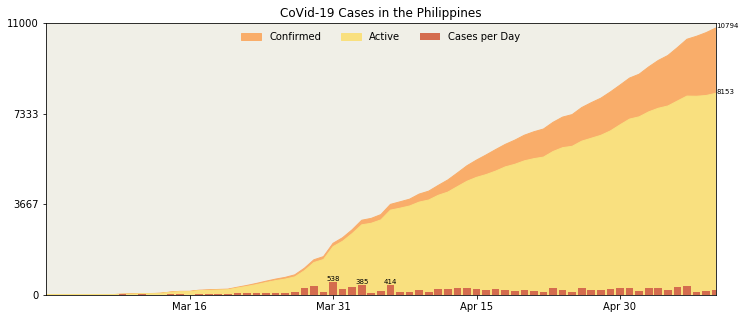

In [32]:
fig = plt.figure(figsize=(12,5))
ax = plt.axes()
ax.set_facecolor('#F0EFE7')
plt.title('CoVid-19 Cases in the Philippines')
plt.fill_between(day_case.index.date, day_case['Confirmed'].cumsum(),
                 (day_case['Confirmed'].cumsum()-(day_case['Death'].cumsum()+day_case['Recovered'].cumsum())),
                 label='Confirmed',
                 color='#f9ad6a')
plt.annotate('%0.f' % day_case['Confirmed'].cumsum()[-1],
             xy=(1, day_case['Confirmed'].cumsum()[-1]),
             xytext=(1, 0),
             xycoords=('axes fraction', 'data'), textcoords='offset points', fontsize= 7)
plt.fill_between(day_case.index.date,
                 (day_case['Confirmed'].cumsum() - (day_case['Death'].cumsum() + day_case['Recovered'].cumsum())), 0,
                 label='Active',
                 color='#f9e07f')
plt.annotate('%0.f' % (day_case['Confirmed'].cumsum()-(day_case['Death'].cumsum()+day_case['Recovered'].cumsum()))[-1],
             xy=(1, (day_case['Confirmed'].cumsum()-(day_case['Death'].cumsum()+day_case['Recovered'].cumsum()))[-1]),
             xytext=(1, 0),
             xycoords=('axes fraction', 'data'), textcoords='offset points', fontsize= 7)
ax.bar(day_case.index.date, day_case['Confirmed'],
       label='Cases per Day',
       color='#d46c4e')
for i in range(3):
    plt.annotate('%0.f' % annotate_bars['Confirmed'][i],
                 xy=(annotate_bars.index[i], annotate_bars['Confirmed'][i]),
                 xytext=(-6.5,1),
                 xycoords=('data', 'data'), textcoords='offset points', fontsize=7, color='#000000')
plt.xlim(day_case.index[12],day_case.index[-1])
plt.xticks([day_case.index[20], day_case.index[-1]])
plt.ylim(0,np.ceil((day_case['Confirmed'].cumsum()[-1])/1000)*1000)
ax.yaxis.set_major_locator(ticker.MultipleLocator((np.ceil((day_case['Confirmed'].cumsum()[-1])/1000)*1000)/3))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('%b %d'))  # format dates as Month-Day eg Mar 01
plt.xlim(pd.Timestamp('2020-03-01'), day_case.index[-1])
plt.xticks(pd.date_range(pd.Timestamp('2020-03-01'), day_case.index[-1] + pd.DateOffset(1),
                         freq='15D', closed='right'))
plt.legend(loc='upper center',
           ncol=3,
           fontsize=10,
           frameon=False)

## Are we flattening the curve?

The orange graph above is the usual graph we're seeing from the different news agencies, the cummulative number of cases we have everyday. This graph alone won't tell us anything if we are indeed flattening the curve. What we can analyze from it is that more than two weeks after an Enhanced Community Quarantine was enforced in the whole Luzon, the cummulative number of cases stopped from being a steep exponential curve, into a more linear curve. Telling that somehow, we are controlling the growth of cases.

What we should be more concerned about is the yellow area and the orange area. The wider the orange area we see in the graph means more and more cases are being resolved. Unlike the orange graph, the yellow graph can be flattened and this should be the graph we are looking at to see if we are indeed flattening the curve.

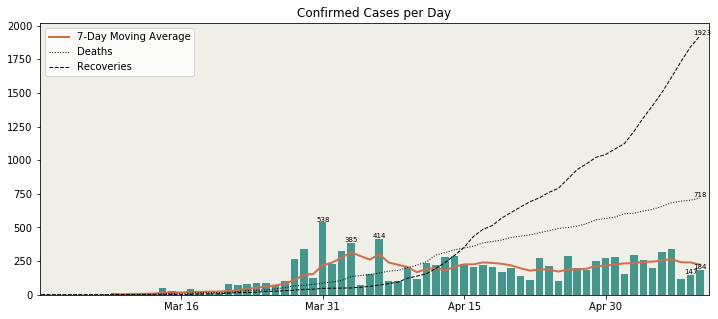

In [33]:
fig2 = plt.figure(figsize=(12,5))
ax = plt.axes()
plt.title('Confirmed Cases per Day')
ax.set_facecolor('#F0EFE7')

ax.bar(day_case.index.date, day_case['Confirmed'],
              color='#43978d')  # was 37AB85
for i in range(5):
    plt.annotate('%0.f' % annotate_bars['Confirmed'][i],
                 xy=(annotate_bars.index[i], annotate_bars['Confirmed'][i]),
                 xytext=(-6.5, 1),
                 xycoords=('data', 'data'), textcoords='offset points', fontsize=7)

plt.plot(day_case.index.date, day_case['Confirmed'].rolling(window= 7).mean(),
         linewidth=2,
         label='7-Day Moving Average',
         color='#d46c4e')  # was FFB052
plt.plot(day_case.index.date, day_case['Death'].cumsum(),
         linestyle= 'dotted',
         linewidth= 1,
         color= '#000000',
         label= 'Deaths')
plt.annotate('%0.f' % day_case['Death'].cumsum()[-1],
             xy=(day_case.index[-1], day_case['Death'].cumsum()[-1]),
             xytext=(-6.5, 1),
             xycoords=('data', 'data'), textcoords='offset points', fontsize= 7)
plt.plot(day_case.index.date, day_case['Recovered'].cumsum(),
         linestyle='--',
         linewidth=1,
         color='#000000',
         label='Recoveries')
plt.annotate('%0.f' % day_case['Recovered'].cumsum()[-1],
             xy=(day_case.index[-1], day_case['Recovered'].cumsum()[-1]),
             xytext=(-6.5, 1),
             xycoords=('data', 'data'), textcoords='offset points', fontsize= 7)
ax.xaxis_date()
ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('%b %d'))  # format dates as Month-Day eg Mar 01
plt.xlim(pd.Timestamp('2020-03-01'), day_case.index[-1] + pd.DateOffset(1))
plt.xticks(pd.date_range(pd.Timestamp('2020-03-01'), day_case.index[-1] + pd.DateOffset(1),
                         freq='15D', closed='right'))
plt.legend(loc='upper left',
           fancybox=True,
           fontsize=10,
           facecolor='#FFFFFF')

The graph above shows our daily cases from March 1. April 15 is a very important date for our country's fight against Covid-19 as this is the day when we have more people who recovered from the disease compared to those who died. There are a lot of issues regarding this data, but we will not concern ourself with those. In the last six days, we had reported the number of cases which are near to each other in values. What we want for this graph is to get the number of cases per day to go smaller and eventually has zero for consecutive days. also, the number of recoveries should continue its exponential growth upward with the number of deaths being minimized to a slow rising linear graph.

## Analysis of Cases Based on Age

Let's look at the extreme cases we had in our country starting from the oldest and youngest confirmed cases. 

In [34]:
print('Oldest Patient is {0} year old {1}, confirmed on {2}.'.format(df['Age'].loc[df['Age'].idxmax()],
                                                                     df['Sex'].loc[df['Age'].idxmax()],
                                                                     df['DateRepConf'].loc[df['Age'].idxmax()].date()))
print('Youngest Patient is {0} year old {1}, confirmed on {2}.'.format(df['Age'].loc[df['Age'].idxmin()],
                                                                       df['Sex'].loc[df['Age'].idxmin()],
                                                                       df['DateRepConf'].loc[df['Age'].idxmin()].date()))
print('Mean age of cases is {0} while median is {1}. Mode is {2}'.format(round(df['Age'].mean()),
                                                                         df['Age'].median(),
                                                                         df['Age'].mode().iloc[0]))

Oldest Patient is 101.0 year old Male, confirmed on 2020-04-06.
Youngest Patient is 0.0 year old Male, confirmed on 2020-04-05.
Mean age of cases is 45.0 while median is 44.0. Mode is 29.0


Let's also look at the extremes and averages for those patients who died.

In [35]:
df_temp = df.loc[df['RemovalType'] == 'Died']
print('Oldest Death is {0} year old {1}, confirmed on {2}.'.format(df_temp['Age'].loc[df_temp['Age'].idxmax()],
                                                                   df_temp['Sex'].loc[df_temp['Age'].idxmax()],
                                                                   df_temp['DateRepConf'].loc[df_temp['Age'].idxmax()].date()))
print('Youngest Death is {0} year old {1}, confirmed on {2}.'.format(df_temp['Age'].loc[df_temp['Age'].idxmin()],
                                                                     df_temp['Sex'].loc[df_temp['Age'].idxmin()],
                                                                     df_temp['DateRepConf'].loc[df_temp['Age'].idxmin()].date()))
print('Mean age of deaths is {0} while median is {1}. Mode is {2}'.format(round(df_temp['Age'].mean()),
                                                                          df_temp['Age'].median(),
                                                                          df_temp['Age'].mode().iloc[0]))
df_temp = df_temp[df_temp['DateDied'].notna()]
print('Mean days to die is {0} days.'.format((df_temp['DateDied'] - df_temp['DateRepConf']).mean().days))
print('Mean days to report death is {0} days.'.format((df_temp['DateRepRem'] - df_temp['DateDied']).mean().days))


Oldest Death is 95.0 year old Female, confirmed on 2020-04-13.
Youngest Death is 0.0 year old Male, confirmed on 2020-04-09.
Mean age of deaths is 64.0 while median is 65.0. Mode is 60.0
Mean days to die is -2 days.
Mean days to report death is 12 days.


Currently, most people who died of Covid-19 had died even before it is confirmed that they have the disease. The DOH is also in backlog in terms of reporting deaths.

Let's now look at the extremes and averages for those patients who recovred.

In [36]:
df_temp = df.loc[df['RemovalType'] == 'Recovered']
print('Oldest Recovery is {0} year old {1}, confirmed on {2}.'.format(df_temp['Age'].loc[df_temp['Age'].idxmax()],
                                                                      df_temp['Sex'].loc[df_temp['Age'].idxmax()],
                                                                      df_temp['DateRepConf'].loc[df_temp['Age'].idxmax()].date()))
print('Youngest Recovery is {0} year old {1}, confirmed on {2}.'.format(df_temp['Age'].loc[df_temp['Age'].idxmin()],
                                                                        df_temp['Sex'].loc[df_temp['Age'].idxmin()],
                                                                        df_temp['DateRepConf'].loc[df_temp['Age'].idxmin()].date()))
print('Mean age of recoveries is {0} while median is {1}. Mode is {2}'.format(round(df_temp['Age'].mean()),
                                                                              df_temp['Age'].median(),
                                                                              df_temp['Age'].mode().iloc[0]))
df_temp = df_temp[df_temp['DateRecover'].notna()]
print('Mean days to recover is {0} days.'.format((df_temp['DateRecover'] - df_temp['DateRepConf']).mean().days))
print('Mean days to report recovery is {0} days.'.format((df_temp['DateRepRem'] - df_temp['DateRecover']).mean().days))


Oldest Recovery is 89.0 year old Female, confirmed on 2020-03-28.
Youngest Recovery is 0.0 year old Male, confirmed on 2020-04-05.
Mean age of recoveries is 47.0 while median is 47.0. Mode is 32.0
Mean days to recover is 12 days.
Mean days to report recovery is 9 days.


Let's analyze the cases based on their age.

In [37]:
case_age = confirmed_removed_group(df, 'AgeGroup', 'AgeGroup')
target_row = case_age[case_age['AgeGroup'] == '5 to 9'].index.values
idx = [0, target_row] + [i for i in range(1, len(case_age)) if i != target_row]
case_age = case_age.iloc[idx].set_index('AgeGroup').fillna(0)

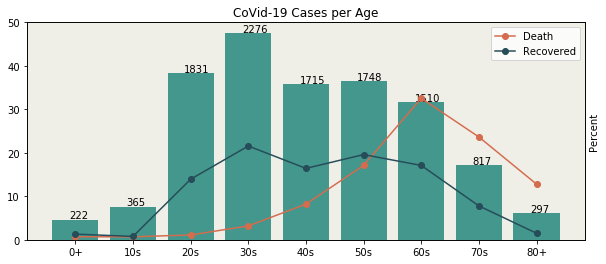

In [38]:
# plot cases per decade
case_age_dec = (case_age + case_age.shift(-1))[:-2:2].append(case_age.iloc[-1]).reset_index()
case_ages_labels = ['0+', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80+']

fig3 = plt.figure(figsize=(10, 4))
ax_count = plt.axes()
plt.title('CoVid-19 Cases per Age')
ax_count.set_facecolor('#F0EFE7')

ax_count.bar(case_age_dec.index, case_age_dec['Confirmed'],
             label='Confirmed',
             color='#43978d')

for i in range(len(case_age_dec)):
    ax_count.annotate('%0.f' % case_age_dec['Confirmed'][i],
                      xy=(case_age_dec.index[i], case_age_dec['Confirmed'][i]),
                      xytext=(-6.5, 1),
                      xycoords=('data', 'data'),
                      textcoords='offset points',
                      fontsize=10)

ax_count.yaxis.set_visible(False)

ax_percent = ax_count.twinx()

ax_percent.plot(case_age_dec.index, (case_age_dec['Death']/case_age_dec['Death'].sum())*100,
                marker='o',
                label='Death',
                color='#d46c4e')
ax_percent.plot(case_age_dec.index, (case_age_dec['Recovered']/case_age_dec['Recovered'].sum())*100,
                marker='o',
                label='Recovered',
                color='#264d59')
ax_percent.set_xticks(case_age_dec.index)
ax_percent.set_xticklabels(case_ages_labels)
ax_percent.set_ylim(0, 50)
ax_percent.yaxis.set_ticks_position('left')
ax_percent.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax_percent.set_ylabel('Percent')
ax_percent.set_xlabel('Age Group')
plt.legend()

The graph shows the distribution of cases per decade of age. It tallies with the mean, median and mode we got above. It can be seen that although most the cases are spread at the ages 20 to 70, the top two age group are those in 20s and 30s. Let's look closer at the timeframes on when these cases happened relative to each other.

In [39]:
def column_to_timewise(df, base_col, date_col):
    df_base = df[[date_col, base_col]]
    df_base = pd.DataFrame(df_base.groupby([date_col, base_col]).size().reset_index(name='count'))
    df_base = df_base.pivot(index=date_col, columns=base_col, values='count').rename_axis(None)
    return df_base.fillna(0)

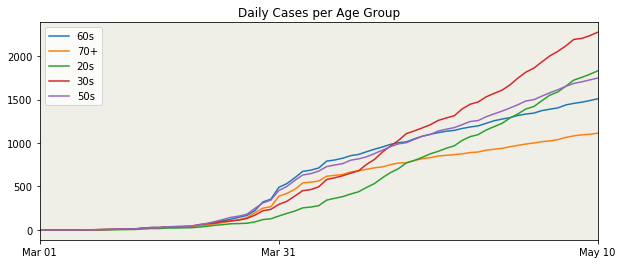

In [40]:
daily_age = column_to_timewise(df, 'AgeGroup', 'DateRepConf')
daily_age_chart = pd.DataFrame(daily_age[['60 to 64', '65 to 69']].sum(axis=1), columns=['60s'])
daily_age_chart['70+'] = daily_age[['70 to 74', '75 to 79', '80+']].sum(axis=1)
daily_age_chart['20s'] = daily_age[['20 to 24', '25 to 29']].sum(axis=1)
daily_age_chart['30s'] = daily_age[['30 to 34', '35 to 39']].sum(axis=1)
daily_age_chart['50s'] = daily_age[['50 to 54', '55 to 59']].sum(axis=1)


fig5 = plt.figure(figsize=(10, 4))
ax = plt.axes()
plt.title('Daily Cases per Age Group')
ax.set_facecolor('#F0EFE7')

ax.plot(daily_age_chart.index.date, daily_age_chart.cumsum())
ax.set_xlim(pd.Timestamp('2020-03-01'), daily_age_chart.index[-1])
ax.set_xticks([pd.Timestamp('2020-03-01'), pd.Timestamp('2020-03-31'), daily_age_chart.index[-1]])
ax.xaxis_date()
ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('%b %d'))

plt.legend(daily_age_chart.columns, loc='upper left')

The graph above shows how the cases evolved over time for the 5 age group. As we can see, the cases for those in their 50s and above almost follows the same shape as the overall cases for the country, while those for ages 20 to 39 rose up since March 31. Early on in this pandemic, the DOH is prioritizing those people in 'vulnerable' sector and age is one of their criteria. There is even a widespread belief that the older you get, the more you are likely to acquire the disease. The rise of cases from those in their 20s and 30s coincides to the time when testing kits are made available to more people and age was removed from the criteria. It just shows that everyone has the same probability of acquiring the disease regardless of their age.

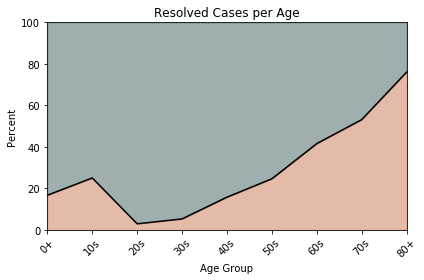

In [41]:
fig4 = plt.figure(figsize=(6, 4))
ax = plt.axes()
plt.title('Resolved Cases per Age')
ax.set_facecolor('#F0EFE7')

div_line = (case_age_dec['Death']/(case_age_dec['Death'] + case_age_dec['Recovered']) * 100)
ax.plot(case_age_dec.index, div_line, color='#000000')
ax.fill_between(case_age_dec.index, 100, div_line, alpha=0.4, color='#264d59')
ax.fill_between(case_age_dec.index, div_line, 0, alpha=0.4, color='#d46c4e')
ax.set_ylim(0, 100)
ax.set_xticklabels(case_ages_labels, rotation='45')
ax.set_xticks(case_age_dec.index)
ax.set_ylabel('Percent')
ax.set_xlabel('Age Group')
# ax.xaxis.set_major_locator(case_age.index)
ax.set_xlim(case_age_dec.index[::len(case_age_dec) - 1])
plt.tight_layout()

If age doesn't matter when it comes to acquiring the disease, it is a different story in terms of how cases were resolved. In the figure above, there is a notable difference in the percentage of patients who recover compared to those who died between the younger and older spectrum of our population. The oldest patients even die about 80% of the time. Children and teenagers also shows to be more likely to succumb to the disease compared to those in their 20s and 30s.

## Analysis Based from Location

The table below shows the Regions in the country with confirmed cases in ascending order. Most of the cases are in NCR and its adjoining regions (Region III and Region IV-A). We can see that CARAGA has the lowest number of cases and BARMM so far has no more active cases. The Easter Visayas and MIMAROPA Regions has the smallest number of cases in Visayas and Luzon respectively. The figure below shows the number of confirmed and active cases for the 12 regions that have less than 100 cases. And the current breakdown of cases for those regions with more than 100 cases except for Central Visayas and NCR.

In [42]:
case_region = confirmed_removed_group(df,'RegionRes', 'RegionRes')
case_region = case_region.sort_values(['Confirmed'], na_position='first', ignore_index=True).fillna(0)
case_region

,RegionRes,Confirmed,Death,Recovered
0,CARAGA,3,0.0,0.0
1,BARMM,11,4.0,7.0
2,Region VIII: Eastern Visayas,18,0.0,4.0
3,Region XII: SOCCSKSARGEN,18,1.0,13.0
4,Region X: Northern Mindanao,19,6.0,6.0
5,Region IV-B: MIMAROPA,28,2.0,9.0
6,Region II: Cagayan Valley,35,1.0,23.0
7,CAR,42,1.0,20.0
8,Region IX: Zamboanga Peninsula,49,2.0,5.0
9,Region V: Bicol Region,60,4.0,7.0


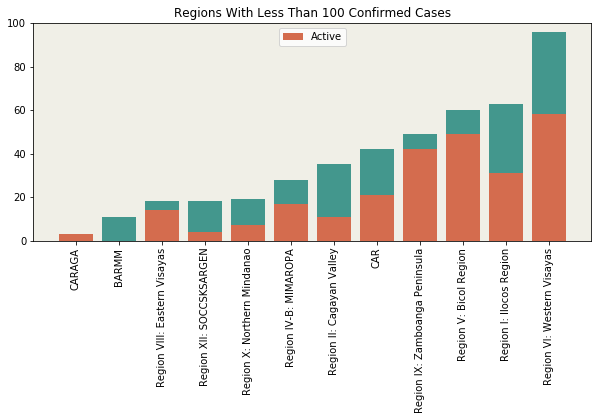

In [43]:
fig7 = plt.figure(figsize=(10, 4))
ax = plt.axes()
plt.title('Regions With Less Than 100 Confirmed Cases')
ax.set_facecolor('#F0EFE7')

ax.bar(case_region[case_region['Confirmed'] < 100]['RegionRes'], case_region[case_region['Confirmed'] < 100]['Confirmed'],
       color='#43978d')

ax.bar(case_region[case_region['Confirmed'] < 100]['RegionRes'], 
       case_region[case_region['Confirmed'] < 100]['Confirmed'] - 
       (case_region[case_region['Confirmed'] < 100]['Recovered'] + case_region[case_region['Confirmed'] < 100]['Death']),
       label='Active',
       color='#d46c4e')
ax.set_xticklabels(case_region[case_region['Confirmed'] < 100]['RegionRes'], rotation='90')
ax.set_xticks(case_region[case_region['Confirmed'] < 100].index)
ax.set_ylim(0,100)
plt.legend(loc= 'upper center')

In [44]:
def my_autopct(pct):
    return ('%.2f%%' % pct) if pct > 0 else ''

In [45]:
def get_new_labels(sizes, labels):
    new_labels = [label if size > 1 else '' for size, label in zip(sizes, labels)]
    return new_labels

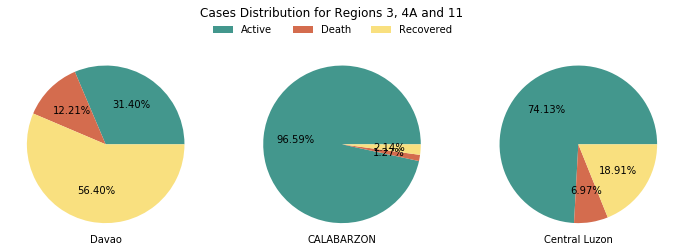

In [46]:
fig6, (axdav, axr4, axr3) = plt.subplots(1, 3, subplot_kw={'aspect': 'equal'}, figsize=(12, 4))
fig6.suptitle('Cases Distribution for Regions 3, 4A and 11')

axdav.set_facecolor('#F0EFE7')
color = ['#43978d', '#d46c4e', '#f9e07f']

axdav.pie(np.insert(case_region.iloc[12,-2:].values, 0, case_region.iloc[12,1] - case_region.iloc[12,-2:].sum()) , autopct=my_autopct,
          #labels=get_new_labels(case_region.iloc[12,-3:], case_region.columns[-3:]),
          colors=color)
axdav.text(0.5, 0, "Davao", size=10, ha="center", transform=axdav.transAxes)

axr4.pie(np.insert(case_region.iloc[15,-2:].values, 0, case_region.iloc[15,1] - case_region.iloc[15,-2:].sum()), autopct=my_autopct,
          #labels=get_new_labels(case_region.iloc[15,-3:], case_region.columns[-3:]),
          colors=color)
axr4.text(0.5, 0, "CALABARZON", size=10, ha="center", transform=axr4.transAxes)

axr3.pie(np.insert(case_region.iloc[13,-2:].values, 0, case_region.iloc[13,1] - case_region.iloc[13,-2:].sum()), autopct=my_autopct,
          #labels=get_new_labels(case_region.iloc[13,-3:], case_region.columns[-3:]),
          colors=color)
axr3.text(0.5, 0, "Central Luzon", size=10, ha="center", transform=axr3.transAxes)

fig6.legend(labels=np.insert(case_region.columns[-2:].values, 0, 'Active'),
           loc='upper center',
           ncol=3,
           fontsize=10,
           frameon=False,
           bbox_to_anchor=(0.385, 0.82))

([<matplotlib.axis.XTick at 0x1d22657c848>,
 <a list of 4 Text xticklabel objects>)

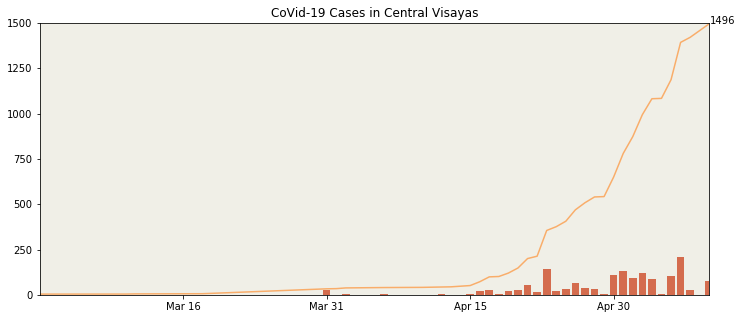

In [47]:
cebu_case = confirmed_removed_group(df[df['RegionRes'] == 'Region VII: Central Visayas'], 'DateRepConf', 'DateRepRem')
cebu_case = cebu_case.drop(columns=['DateRepRem_x', 'DateRepRem_y']).set_index('DateRepConf').fillna(0)

annotate_bars = cebu_case.nlargest(3, ['Confirmed']).append(cebu_case.tail(2))

fig = plt.figure(figsize=(12,5))
ax = plt.axes()
ax.set_facecolor('#F0EFE7')
plt.title('CoVid-19 Cases in Central Visayas')

ax.plot(cebu_case.index.date, cebu_case['Confirmed'].cumsum(),
                 label='Confirmed',
                 color='#f9ad6a')
ax.annotate('%0.f' % cebu_case['Confirmed'].cumsum()[-1],
             xy=(cebu_case.index.date[-1], cebu_case['Confirmed'].cumsum()[-1]),
             xytext=(1, 0),
             xycoords=('data', 'data'), textcoords='offset points', fontsize= 10)
ax.bar(cebu_case.index.date, cebu_case['Confirmed'],
       label='Cases per Day',
       color='#d46c4e')
plt.ylim(0,np.ceil((cebu_case['Confirmed'].cumsum()[-1])/100)*100)
ax.yaxis.set_major_locator(ticker.MultipleLocator((np.ceil((cebu_case['Confirmed'].cumsum()[-1])/100)*100)/6))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('%b %d'))  # format dates as Month-Day eg Mar 01
plt.xlim(pd.Timestamp('2020-03-01'), cebu_case.index[-1])
plt.xticks(pd.date_range(pd.Timestamp('2020-03-01'), cebu_case.index[-1] + pd.DateOffset(1),
                         freq='15D', closed='right'))

As we can see, the cases in Central Visayas started to blew up since April 15 with majority of the cases coming from Cebu City. Medical officials attribute this rise in cases to the massive testing and expansion of the testing capacity of the subnational laboratory (SNL) found in Vicente Sotto Memorial Medical Center (VSMMC) where even people without symptoms are being tested. [https://cebudailynews.inquirer.net/308460/majority-of-new-covid-19-cases-in-the-country-are-from-central-visayas#ixzz6LlZrhkbm]


In [48]:
def min_max_norm(df):
    return (df-df.min())/(df.max()-df.min())

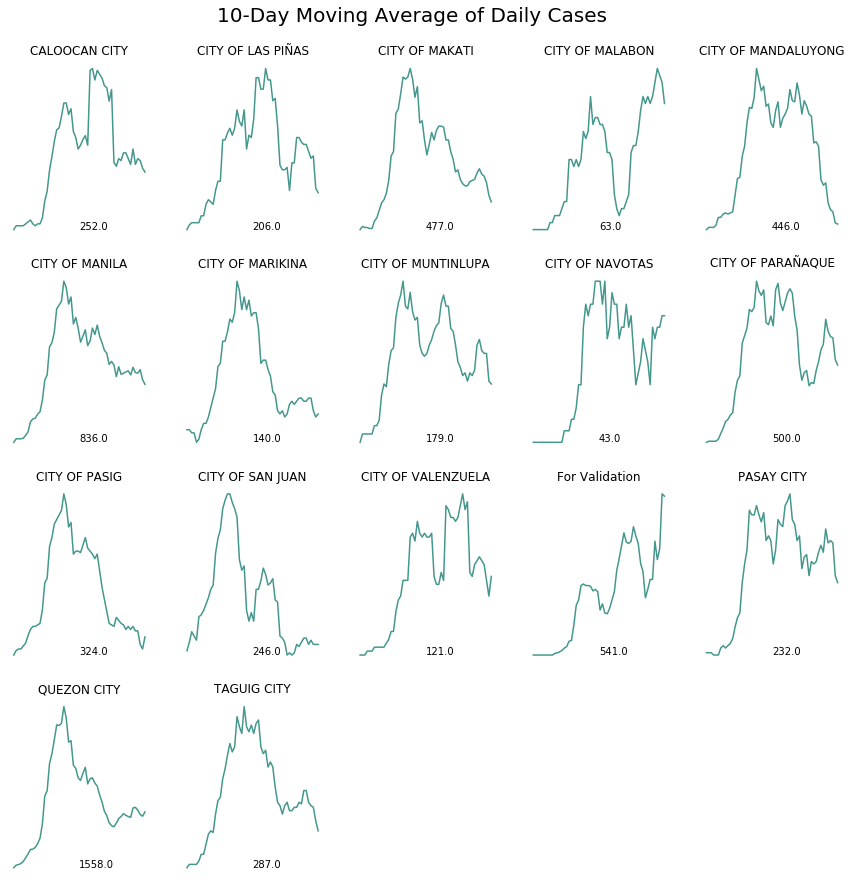

In [49]:
ncr_case = column_to_timewise(df[df['ProvRes'] ==  'METRO MANILA'], 'CityMunRes', 'DateRepConf')

fig6, ax = plt.subplots(4,5,figsize=(15,15)) # subplot_kw={'aspect': 'equal'}, figsize=(2,2))
fig6.suptitle('10-Day Moving Average of Daily Cases', fontsize=20, y=0.93)

ncr_norm = min_max_norm(ncr_case.rolling(window=10).mean())
cities = np.pad(np.array(ncr_norm.columns), (0, 20 - len(ncr_norm.columns)), 'constant')
cities = cities.reshape(4,5)

for i, city in enumerate(cities):
    for j, town in enumerate(city):
        if town == 0:
            ax[i,j].set_axis_off()
        else:
            ax[i,j].plot(ncr_norm.index.date, ncr_norm[town], color='#43978d')
            ax[i,j].set_aspect('auto', 'box')
            ax[i,j].set_axis_off()
            ax[i,j].set_title(town)
            ax[i,j].set_facecolor('#F0EFE7')
            ax[i,j].text(0.5, 0.05, ncr_case[town].cumsum()[-1], transform=ax[i,j].transAxes)

## Health Status and Hospitalization of Cases

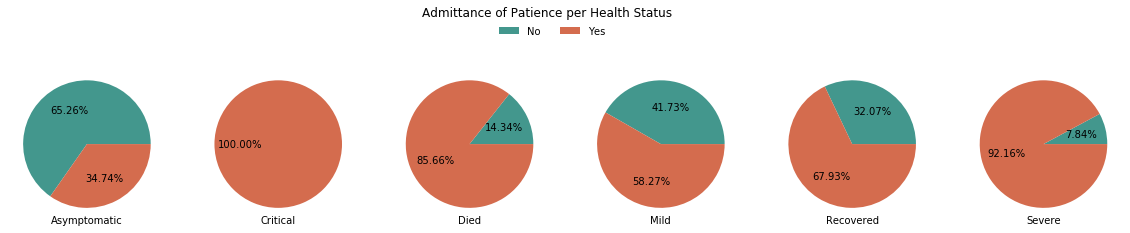

In [50]:
how_cases = df[['Admitted', 'HealthStatus']]
how_cases = how_cases.groupby(['HealthStatus','Admitted']).size().reset_index(name='count')
how_cases = how_cases.pivot(index='HealthStatus', columns='Admitted', values='count').rename_axis(None).fillna(0)

 
fig, ax = plt.subplots(1, len(how_cases), subplot_kw={'aspect': 'equal'}, figsize=(20, 4))
fig.suptitle('Admittance of Patience per Health Status')

color = ['#43978d', '#d46c4e']
for i in range(len(how_cases)):
    ax[i].pie(how_cases.iloc[i], autopct=my_autopct, colors=color)
    ax[i].text(0.5, 0, how_cases.index[i], size=10, ha="center", transform=ax[i].transAxes)
fig.legend(labels=how_cases.columns.values,
           loc='upper left',
           ncol=3,
           fontsize=10,
           frameon=False,
           bbox_to_anchor=(0.34,0.75))

## Testing

DOH keeps a different file on reporting their testing. Let's load it and plot the number of unique individual tested per day.

In [51]:
df = pd.read_csv('datafiles\doh\DOH COVID Data Drop_ 20200510 - 08 Testing Aggregates.csv',
                 parse_dates=['Date'], thousands=',')

In [52]:
columns = [col for col in df.columns if col not in ['Name of Health Facility/Laboratory', 'Abbrev of Health Facility',
                                                    'Date']]
for column in columns:
    df[column] = pd.to_numeric(df[column], errors='coerce', downcast='float')
# df = df.apply(pd.to_numeric, errors='ignore', downcast='float')
test_dates = df.groupby(['Date']).sum() #.reset_index()
test_daily = (test_dates - test_dates.shift(1))[1:]

test_annotations = test_daily.nlargest(3,['UNIQUE INDIVIDUALS TESTED']).append(test_daily.tail(2)).append(test_daily.nsmallest(2,['UNIQUE INDIVIDUALS TESTED']))

In [53]:
def regress_line_time(y):
    x = np.arange(len(y)).reshape(-1, 1)
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(x, y)  # perform linear regression
    y_pred = linear_regressor.predict(x)  # make predictions
    return y_pred

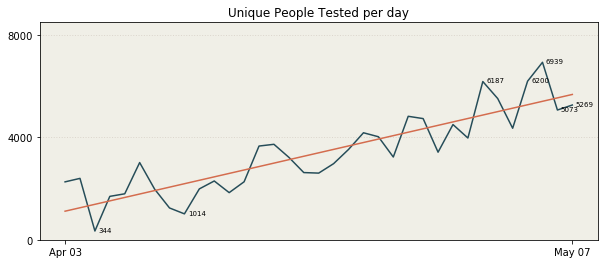

In [54]:
fig7 = plt.figure(figsize=(10, 4))
ax_unique = plt.axes()
plt.title('Unique People Tested per day')
ax_unique.set_facecolor('#F0EFE7')

ax_unique.plot(test_daily.index, test_daily['UNIQUE INDIVIDUALS TESTED'], color='#264d59')
for i in range(len(test_annotations)):
    ax_unique.annotate('%0.f' % test_annotations['UNIQUE INDIVIDUALS TESTED'][i], 
                        xy=(test_annotations.index[i], test_annotations['UNIQUE INDIVIDUALS TESTED'][i]),
                        xytext=(3.5, -1),
                        xycoords=('data', 'data'), textcoords='offset points', fontsize=7)

regress_line = regress_line_time(test_daily['UNIQUE INDIVIDUALS TESTED'].values.reshape(-1, 1))
ax_unique.plot(test_daily.index, regress_line, color='#d46c4e')
ax_unique.xaxis.set_major_formatter(mpl_dates.DateFormatter('%b %d'))  # format dates as Month-Day eg Mar 01
ax_unique.set_xticks([test_daily.index[0], test_daily.index[-1]])
ax_unique.set_ylim(0, 8500)
ax_unique.set_yticks([0, 4000, 8000])
ax_unique.grid(axis='y', color='#dcd6cd', linestyle='dotted', linewidth=1)

Overall, we are generally increasing the number of individuals being tested as shown by the upward movement of the red regression line. However, we are still a long way from the target 8000 people tested daily. News says that four new megaswabbing facilities will be upped within the month that can bring the number close to 30,000 individuals tested per day.